In [2]:
import sys
sys.path.append('../code/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import nibabel as nib

from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker

from functools import partial

from mamba_ssm import Mamba

import utils

device = torch.device("cuda:0")
# device = torch.device("cpu")

--No graphics will be displayed.


In [3]:
# https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_inverse_covariance_connectome.html#sphx-glr-auto-examples-03-connectivity-plot-inverse-covariance-connectome-py

In [4]:
# data_dir = '/users/ntolley/scratch/metanets_data/'

# atlas = datasets.fetch_atlas_msdl()
# # Loading atlas image stored in 'maps'
# atlas_filename = atlas["maps"]
# # Loading atlas data stored in 'labels'
# labels = atlas["labels"]

# # Loading the functional datasets
# data = datasets.fetch_development_fmri(data_dir=data_dir)



In [5]:
# masker = NiftiMapsMasker(
#     maps_img=atlas_filename,
#     standardize="zscore_sample",
#     standardize_confounds="zscore_sample",
#     memory="nilearn_cache",
#     verbose=5,
# )

# n_subjects = 100

# df_list = list()
# for subj_idx in range(n_subjects):
#     time_series = masker.fit_transform(data.func[subj_idx], confounds=data.confounds)
#     df_temp = pd.DataFrame(time_series)
#     df_temp['subj'] = np.repeat(subj_idx, len(df_temp))

#     df_list.append(df_temp)

# df = pd.concat(df_list)

In [6]:
# df.to_pickle('../data/developmental_df.pkl') 
df = pd.read_pickle('../data/developmental_df.pkl')

In [7]:
class model_ann(nn.Module):
    def __init__(self, input_size, output_size, layer_size, dropout=0.0):
        super(model_ann, self).__init__()
        self.input_size,  self.layer_size, self.output_size = input_size, layer_size, output_size

        #List layer sizes
        self.layer_hidden = np.concatenate([[input_size], layer_size, [output_size]])
        
        #Compile layers into lists
        self.layer_list = nn.ModuleList(
            [nn.Linear(in_features=self.layer_hidden[idx], out_features=self.layer_hidden[idx+1]) for idx in range(len(self.layer_hidden)-1)] )

        self.dropout_list = [nn.Dropout(p=dropout) for _ in range(len(self.layer_list)-1)]
 
    def forward(self, x):
        #Encoding step
        for idx in range(len(self.layer_list) - 1):
            x = torch.tanh(self.layer_list[idx](x))
            x = self.dropout_list[idx](x)
        x = self.layer_list[-1](x)
        return x

# class model_ann_autoencoder(nn.Module):
#     def __init__(self, input_size, output_size, encoder_layer_size, decoder_layer_size, bottleneck = 10):
#         super(model_ann_autoencoder, self).__init__()
#         self.input_size, self.output_size = input_size, output_size
#         self.encoder_layer_size, self.decoder_layer_size = encoder_layer_size, decoder_layer_size

#         self.encoder = model_ann(input_size, bottleneck, layer_size=self.encoder_layer_size)
#         self.decoder = model_ann(bottleneck, input_size, layer_size=self.decoder_layer_size)

#     def forward(self, x):
#         out = self.encoder(x)
#         out = self.decoder(out)

#         return out

In [89]:
class model_mamba(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers, dropout, device='cpu'):
        super(model_lstm, self).__init__()

        # Defining some parameters
        self.device = device
        self.input_size = input_size

    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden, cell = self.init_hidden(batch_size)

        # out, (hidden, cell) = self.lstm(x, (hidden, cell))
        out = self.lstm(x)

        return out



class model_mamba_autoencoder(nn.Module):
    def __init__(self, input_size, encoder_hidden, decoder_hidden,
                 bottleneck=10, device='cpu'):
        super(model_mamba_autoencoder, self).__init__()
        self.input_size = input_size
        self.encoder_hidden, self.decoder_hidden = encoder_hidden, decoder_hidden
        self.bottleneck = bottleneck

        self.encoder_mamba = Mamba(d_model=self.encoder_hidden, d_state=16, d_conv=4, expand=2).to(device)
        self.decoder_mamba = Mamba(d_model=self.decoder_hidden, d_state=16, d_conv=4, expand=2).to(device)

        self.fc_in = nn.Linear(self.input_size, self.encoder_hidden)
        self.fc_out = nn.Linear(self.decoder_hidden, self.input_size)
        self.encoder_ann = nn.Linear(encoder_hidden, bottleneck)
        self.decoder_ann = nn.Linear(bottleneck, decoder_hidden)

    def forward(self, x):
        out = x.contiguous()
        out = self.fc_in(out)
        out = self.encoder_mamba(out)
        out = self.encoder_ann(out)

        out = self.decoder_ann(out)
        out = self.decoder_mamba(out)
        out = self.fc_out(out)
        return out



In [90]:
class fmri_dataset(torch.utils.data.Dataset):
     def __init__(self, cv_dict, fold, partition, df, window_size=100, data_step_size=1, scaler=None, device=device):
          self.cv_dict = cv_dict
          self.fold = fold
          self.partition = partition
          self.df = df
          self.window_size = window_size
          self.data_step_size = data_step_size

          self.smooth_func = partial(smooth_waveform, window_len=10, sfreq=1000)

          self.subj_idx = cv_dict[fold][partition]
          self.num_subj = len(self.subj_idx) 
          self.data_list = self.process_dfs(self.df)

          if scaler is None:
               self.scaler = StandardScaler()
               self.scaler.fit(np.vstack(self.data_list))
          else:
               self.scaler = scaler

          self.X_tensor = self.format_splits(self.data_list)
          
     def __len__(self):
        #'Denotes the total number of samples'
        return self.num_subj

     def process_dfs(self, df):
          data_list = list()
          for subj in self.subj_idx:
               df_filtered = df[df['subj'] == subj]
               subj_values = df_filtered.values
               data_list.append(subj_values)
          return data_list

     def format_splits(self, data_list):
          unfolded_data_list = list()
          for trial_idx in range(self.num_subj):
               subj_data = torch.from_numpy(self.scaler.transform(data_list[trial_idx]))
            
               unfolded_subj = subj_data.unfold(0, self.window_size, self.data_step_size).transpose(1, 2)
               unfolded_data_list.append(unfolded_subj)
        
          data_tensor = torch.concat(unfolded_data_list, axis=0)
          return data_tensor

          
     def __getitem__(self, slice_index):
          return self.X_tensor[slice_index,:,:]

In [91]:
n_subjects = 155

cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(n_subjects))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [92]:
batch_size = 10_000
num_cores = 1

train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}


In [93]:
fold = 0

# Generators
training_set = fmri_dataset(cv_dict, fold, 'train_idx', df, scaler=None)
scaler = training_set.scaler

training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

validation_set = fmri_dataset(cv_dict, fold, 'validation_idx', df, scaler=scaler)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

testing_set = fmri_dataset(cv_dict, fold, 'test_idx', df, scaler=scaler)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)

data_arrays = (training_set, validation_set, testing_set)
generators = (training_generator, training_eval_generator, validation_generator, testing_generator)



In [102]:
#Define hyperparameters
lr = 1e-3
weight_decay = 0.0
max_epochs = 1000
input_size = training_set[0].shape[1]
criterion = nn.MSELoss()

bottleneck = 10

encoder_hidden = 1000
decoder_hidden = lstm_encoder_hidden


# model = model_ann_autoencoder(input_size=input_size, output_size=input_size,
#                               encoder_layer_size=encoder_layer_size, decoder_layer_size=decoder_layer_size,
#                               bottleneck=bottleneck).to(device)

model = model_mamba_autoencoder(input_size, encoder_hidden, decoder_hidden,
                               bottleneck=bottleneck, device=device).to(device)

# Define Loss, Optimizerints h
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

#Train model
loss_dict = utils.train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 300)

*.***.....
Epoch: 10/1000 ... Train Loss: 0.7116  ... Validation Loss: 0.8696
**********
Epoch: 20/1000 ... Train Loss: 0.4520  ... Validation Loss: 0.7399
****.*****
Epoch: 30/1000 ... Train Loss: 0.2919  ... Validation Loss: 0.6654
**********
Epoch: 40/1000 ... Train Loss: 0.2019  ... Validation Loss: 0.6237
*****.....
Epoch: 50/1000 ... Train Loss: 0.1410  ... Validation Loss: 0.6179
......**..
Epoch: 60/1000 ... Train Loss: 0.0986  ... Validation Loss: 0.6152
..........
Epoch: 70/1000 ... Train Loss: 0.0682  ... Validation Loss: 0.6289
..........
Epoch: 80/1000 ... Train Loss: 0.0467  ... Validation Loss: 0.6612
..........
Epoch: 90/1000 ... Train Loss: 0.0315  ... Validation Loss: 0.7127
..........
Epoch: 100/1000 ... Train Loss: 0.0216  ... Validation Loss: 0.7358
..........
Epoch: 110/1000 ... Train Loss: 0.0145  ... Validation Loss: 0.7621
..........
Epoch: 120/1000 ... Train Loss: 0.0154  ... Validation Loss: 0.7852
..........
Epoch: 130/1000 ... Train Loss: 0.0091  ... Valida

/tmp/ipykernel_1395518/3866458040.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(model(torch.tensor(validation_set[:][:,-1:,:]).float().to(device)).detach().cpu().numpy()[:, 0, roi_idx], color='r', alpha=0.8, label='Reconstruction')


Text(0, 0.5, 'ROI Activation')

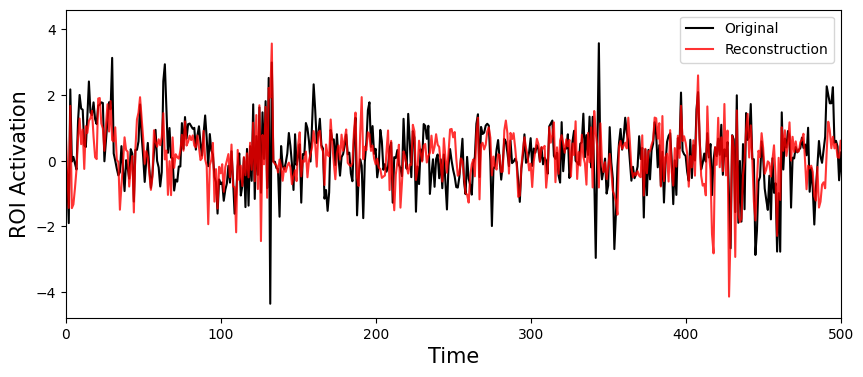

In [105]:
labelsize = 15

plt.figure(figsize=(10,4))
roi_idx = 20

model.eval()
plt.plot(validation_set[:][:,-1:,:][:,0,roi_idx].detach().cpu().numpy(), color='k', label='Original')
plt.plot(model(torch.tensor(validation_set[:][:,-1:,:]).float().to(device)).detach().cpu().numpy()[:, 0, roi_idx], color='r', alpha=0.8, label='Reconstruction')
plt.xlim(0,500)
plt.legend()
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('ROI Activation', fontsize=labelsize)


/tmp/ipykernel_1395518/3959396204.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(model(torch.tensor(training_set[:][:,-1:,:]).float().to(device)).detach().cpu().numpy()[:, 0, roi_idx], color='r', alpha=0.8, label='Reconstruction')


Text(0, 0.5, 'ROI Activation')

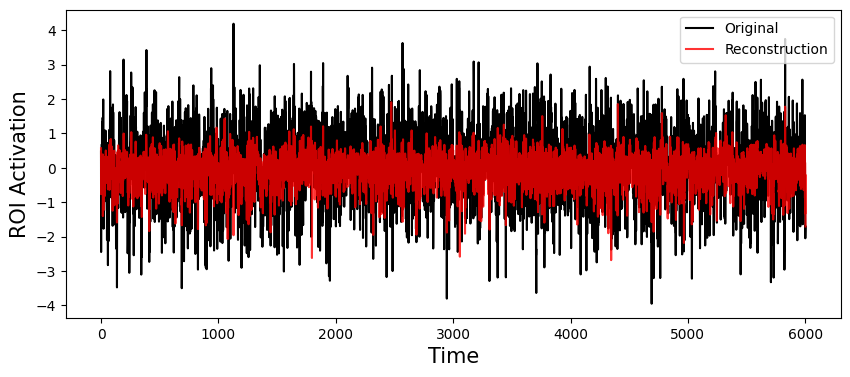

In [31]:
labelsize = 15

plt.figure(figsize=(10,4))
roi_idx = 30
model.eval()
plt.plot(training_set[:][:,-1:,:][:,0,roi_idx].detach().cpu().numpy(), color='k', label='Original')
plt.plot(model(torch.tensor(training_set[:][:,-1:,:]).float().to(device)).detach().cpu().numpy()[:, 0, roi_idx], color='r', alpha=0.8, label='Reconstruction')
# plt.xlim(100,200)
plt.legend()
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('ROI Activation', fontsize=labelsize)
